# Load libraries

In [1]:
library(ggplot2)
library(DiffBind)
library(DESeq2)
library(edgeR)
library(tidyr)
library(dplyr)
library(rtracklayer)
library(ChIPseeker)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb



# Run ATAC DiffBind analysis and generate MA plot

In [2]:
# Load in data
ATAC <- dba(sampleSheet = "/n/groups/neuroduo/Bruno/Astro_GR_KO_ATAC/Astro_GR_KO_ATAC_sample_sheet.csv", peakFormat="narrow")
ATAC_count <- dba.count(ATAC,summits=200,minOverlap=2,bParallel = TRUE)

Cre_pos_R1 Astro ATAC Cre Cre 1 bed

Cre_pos_R2 Astro ATAC Cre Cre 2 bed

Cre_pos_R3 Astro ATAC Cre Cre 3 bed

delCre_pos_R1 Astro ATAC delCre delCre 1 bed

delCre_pos_R2 Astro ATAC delCre delCre 2 bed

delCre_pos_R3 Astro ATAC delCre delCre 3 bed

Computing summits...

Re-centering peaks...



6 Samples, 137900 sites in matrix:
             ID Tissue Factor Condition Treatment Replicate    Reads FRiP
1    Cre_pos_R1  Astro   ATAC       Cre       Cre         1 28285716 0.41
2    Cre_pos_R2  Astro   ATAC       Cre       Cre         2 26697314 0.45
3    Cre_pos_R3  Astro   ATAC       Cre       Cre         3 27083023 0.42
4 delCre_pos_R1  Astro   ATAC    delCre    delCre         1 26748885 0.45
5 delCre_pos_R2  Astro   ATAC    delCre    delCre         2 26895372 0.45
6 delCre_pos_R3  Astro   ATAC    delCre    delCre         3 30637589 0.41

In [3]:
# Normalize counts
ATAC_count <- dba.normalize(ATAC_count, method = DBA_ALL_METHODS)

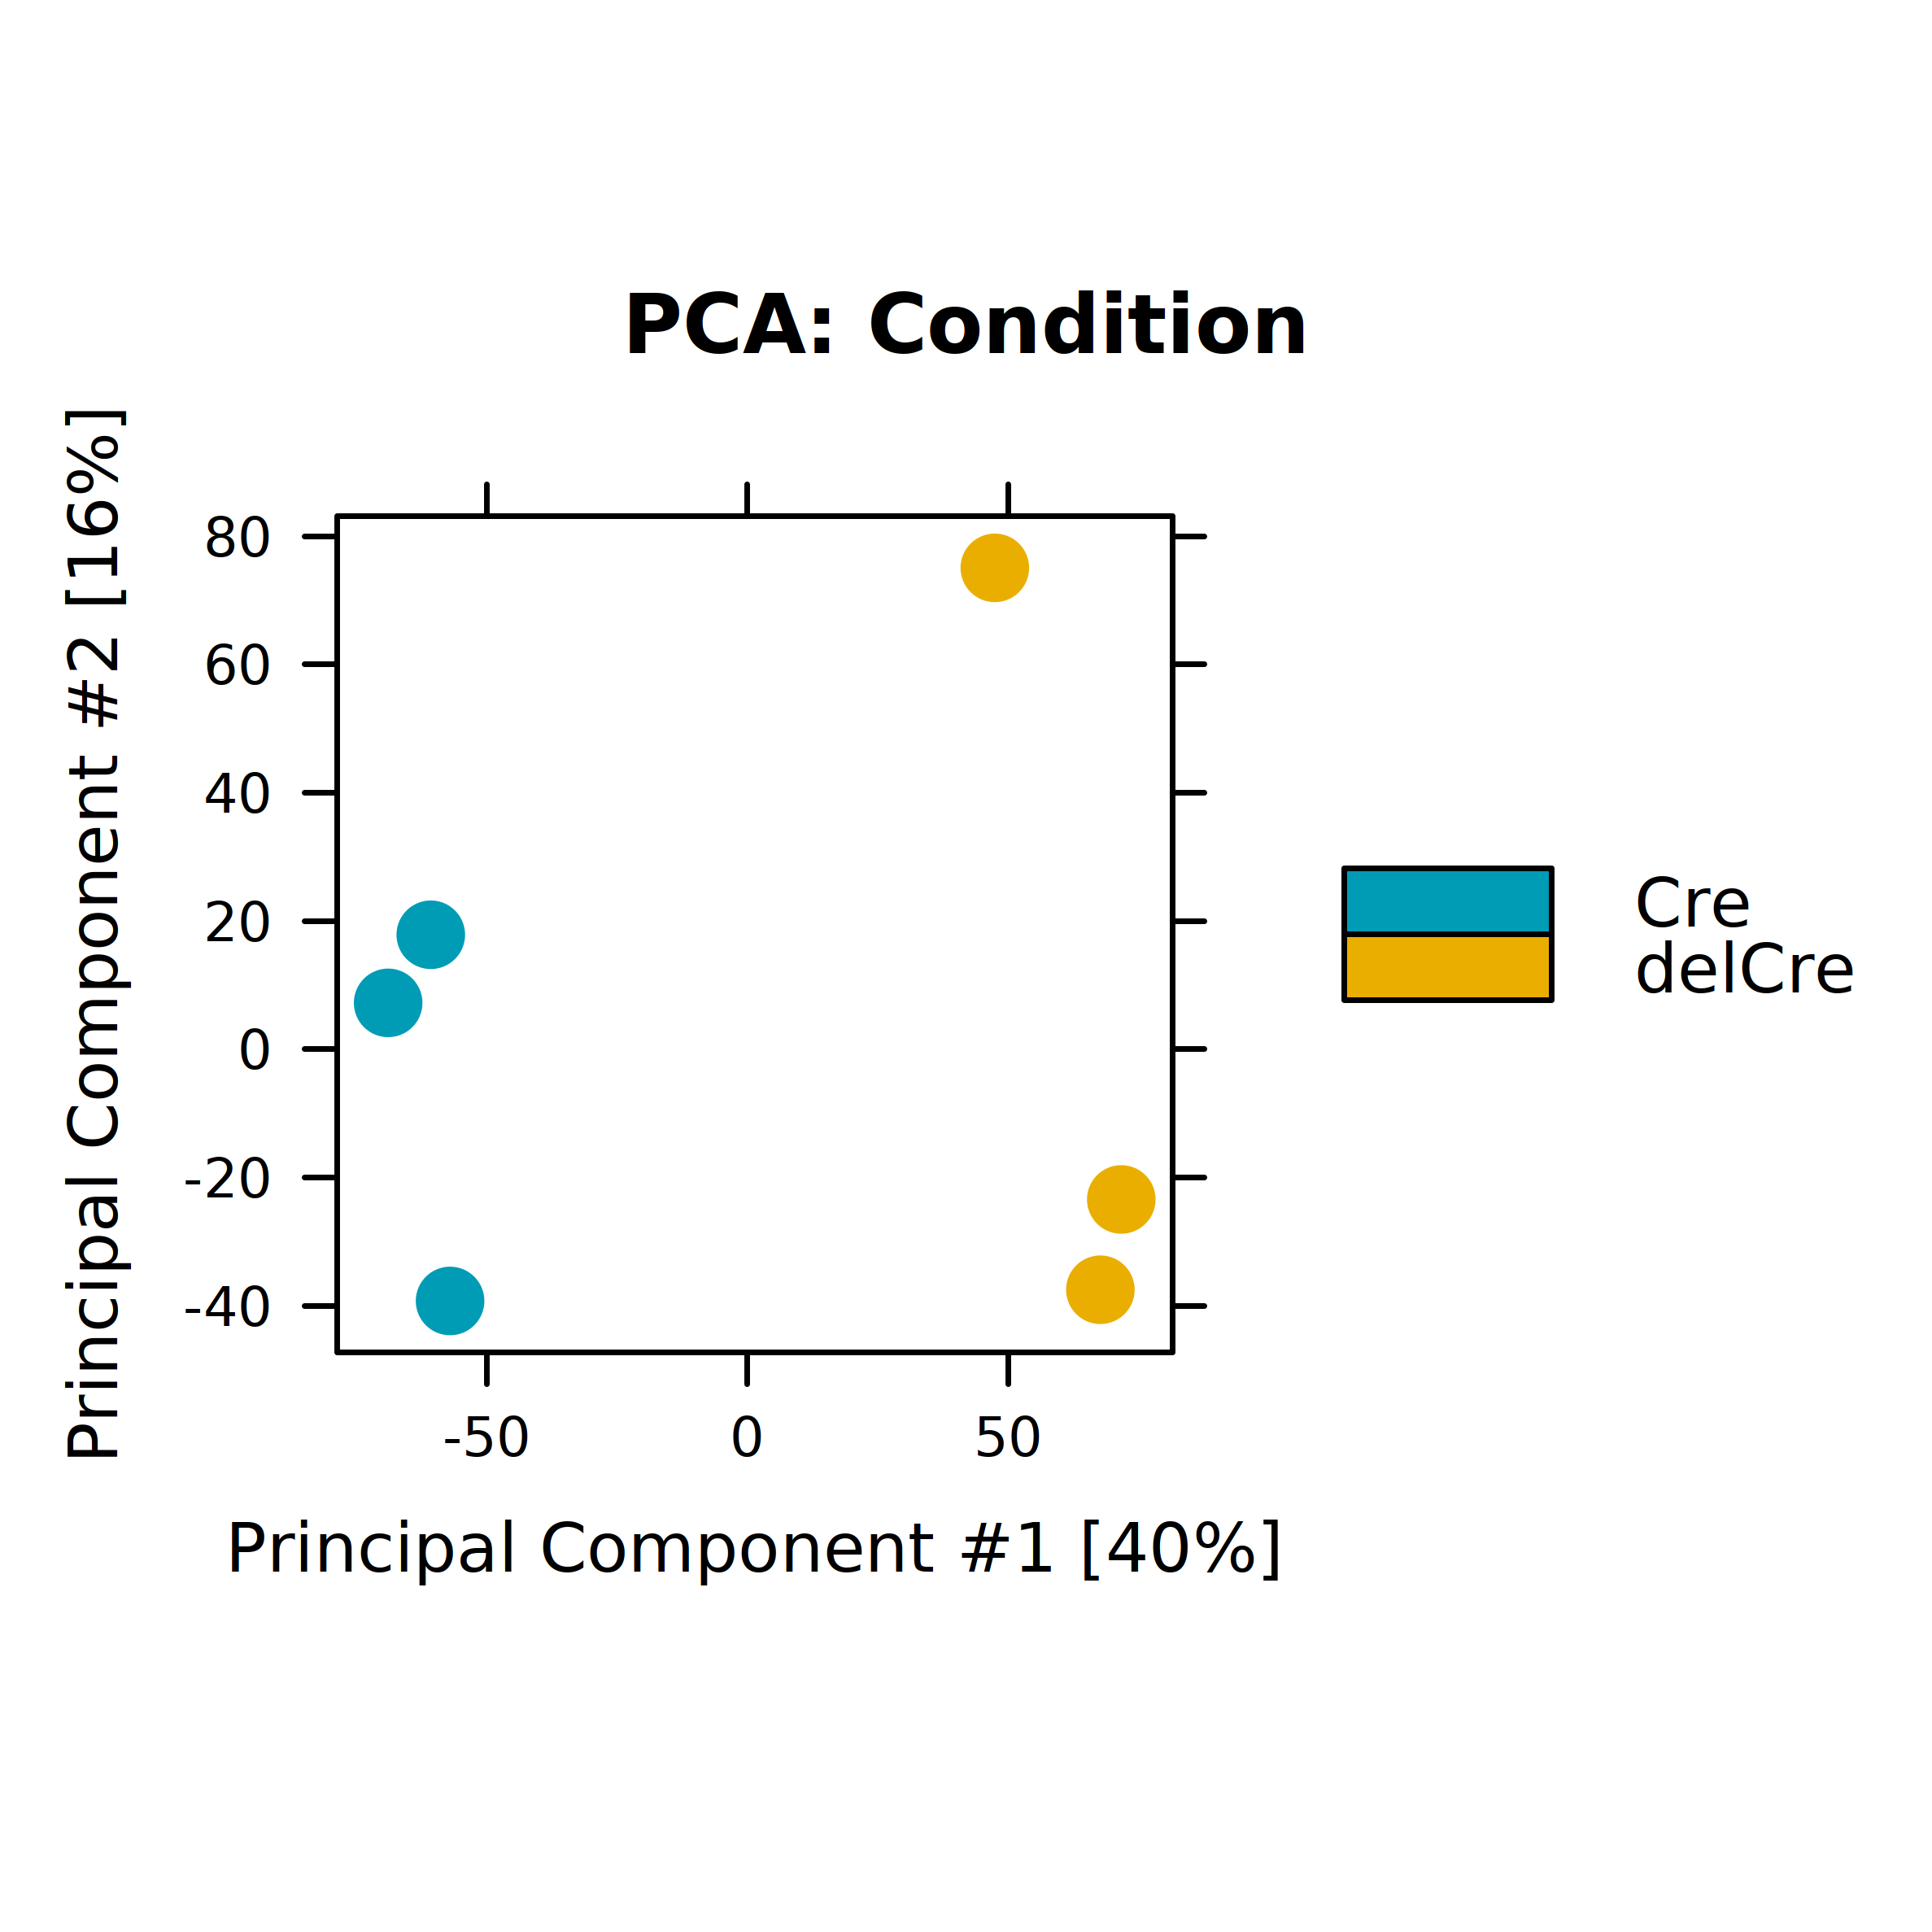

In [4]:
# Generate PCA plot
options(repr.plot.width=4.75, repr.plot.height=4.75,repr.plot.res=500)
p <- dba.plotPCA(ATAC_count,
            score = DBA_SCORE_RPKM,
             dotSize=2,
            vColors = c("#009CB5","#EAAE00"))

In [5]:
# Establish contrast
ATAC_count_contrast <- dba.contrast(ATAC_count, reorderMeta=list(Condition="Cre"),minMembers=2)

Computing results names...



In [6]:
# Run analysis
ATAC_count_edger <- dba.analyze(ATAC_count_contrast,
                                method=DBA_EDGER,
                                bBlacklist=FALSE,
                                bGreylist = FALSE)

Analyzing...



In [10]:
# Export sig sites
ATAC_count_edger_report <- dba.report(ATAC_count_edger,th=0.05,fold=0.25,method=DBA_EDGER,bFlip=TRUE)

In [11]:
# Annotate GR sites to mm10
txdb <- TxDb.Mmusculus.UCSC.mm10.knownGene
peakAnno <- annotatePeak(ATAC_count_edger_report,
                         tssRegion=c(-1000, 1000),
                         genomicAnnotationPriority = c("Promoter", "Exon", "Intron",
                                                        "Downstream", "Intergenic"),
                         level = 'gene',
                         TxDb=txdb, annoDb="org.Mm.eg.db")

>> preparing features information...		 2025-05-27 10:20:58 PM 
>> identifying nearest features...		 2025-05-27 10:20:59 PM 
>> calculating distance from peak to TSS...	 2025-05-27 10:20:59 PM 
>> assigning genomic annotation...		 2025-05-27 10:20:59 PM 
>> adding gene annotation...			 2025-05-27 10:21:05 PM 


Loading required package: org.Mm.eg.db



'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2025-05-27 10:21:05 PM 
>> done...					 2025-05-27 10:21:05 PM 


In [16]:
# Export data with nearest gene annotation
write.table(cbind(as.data.frame(ATAC_count_edger_report),as.data.frame(peakAnno)$SYMBOL),
            '/n/groups/neuroduo/Bruno/Astro_GR_KO_ATAC/SuppTable8.csv',
            quote=FALSE,
            row.names=FALSE,
            col.names=TRUE,
            sep=',')

In [8]:
# Export all sites to df
ATAC_count_edger_df <- as.data.frame(dba.report(ATAC_count_edger,th=1,method=DBA_EDGER,bFlip=TRUE))

In [9]:
# Add a column of NAs
ATAC_count_edger_df$significant <- "NO"

# Set differential motifs to "experience-induced or -repressed"
ATAC_count_edger_df$significant[ (ATAC_count_edger_df$Fold > 0) & 
                                (paste0(ATAC_count_edger_df$seqnames,ATAC_count_edger_df$start,ATAC_count_edger_df$end) %in% 
                                 paste0(ATAC_count_edger_report$seqnames,ATAC_count_edger_report$start,ATAC_count_edger_report$end))] <- "Up"

ATAC_count_edger_df$significant[ (ATAC_count_edger_df$Fold < 0) & 
                                 (paste0(ATAC_count_edger_df$seqnames,ATAC_count_edger_df$start,ATAC_count_edger_df$end) %in% 
                                 paste0(ATAC_count_edger_report$seqnames,ATAC_count_edger_report$start,ATAC_count_edger_report$end))] <- "Down"

In [11]:
# Set factor level for plotting
ATAC_count_edger_df$significant <- factor(ATAC_count_edger_df$significant,levels =c('Up','Down','NO'))

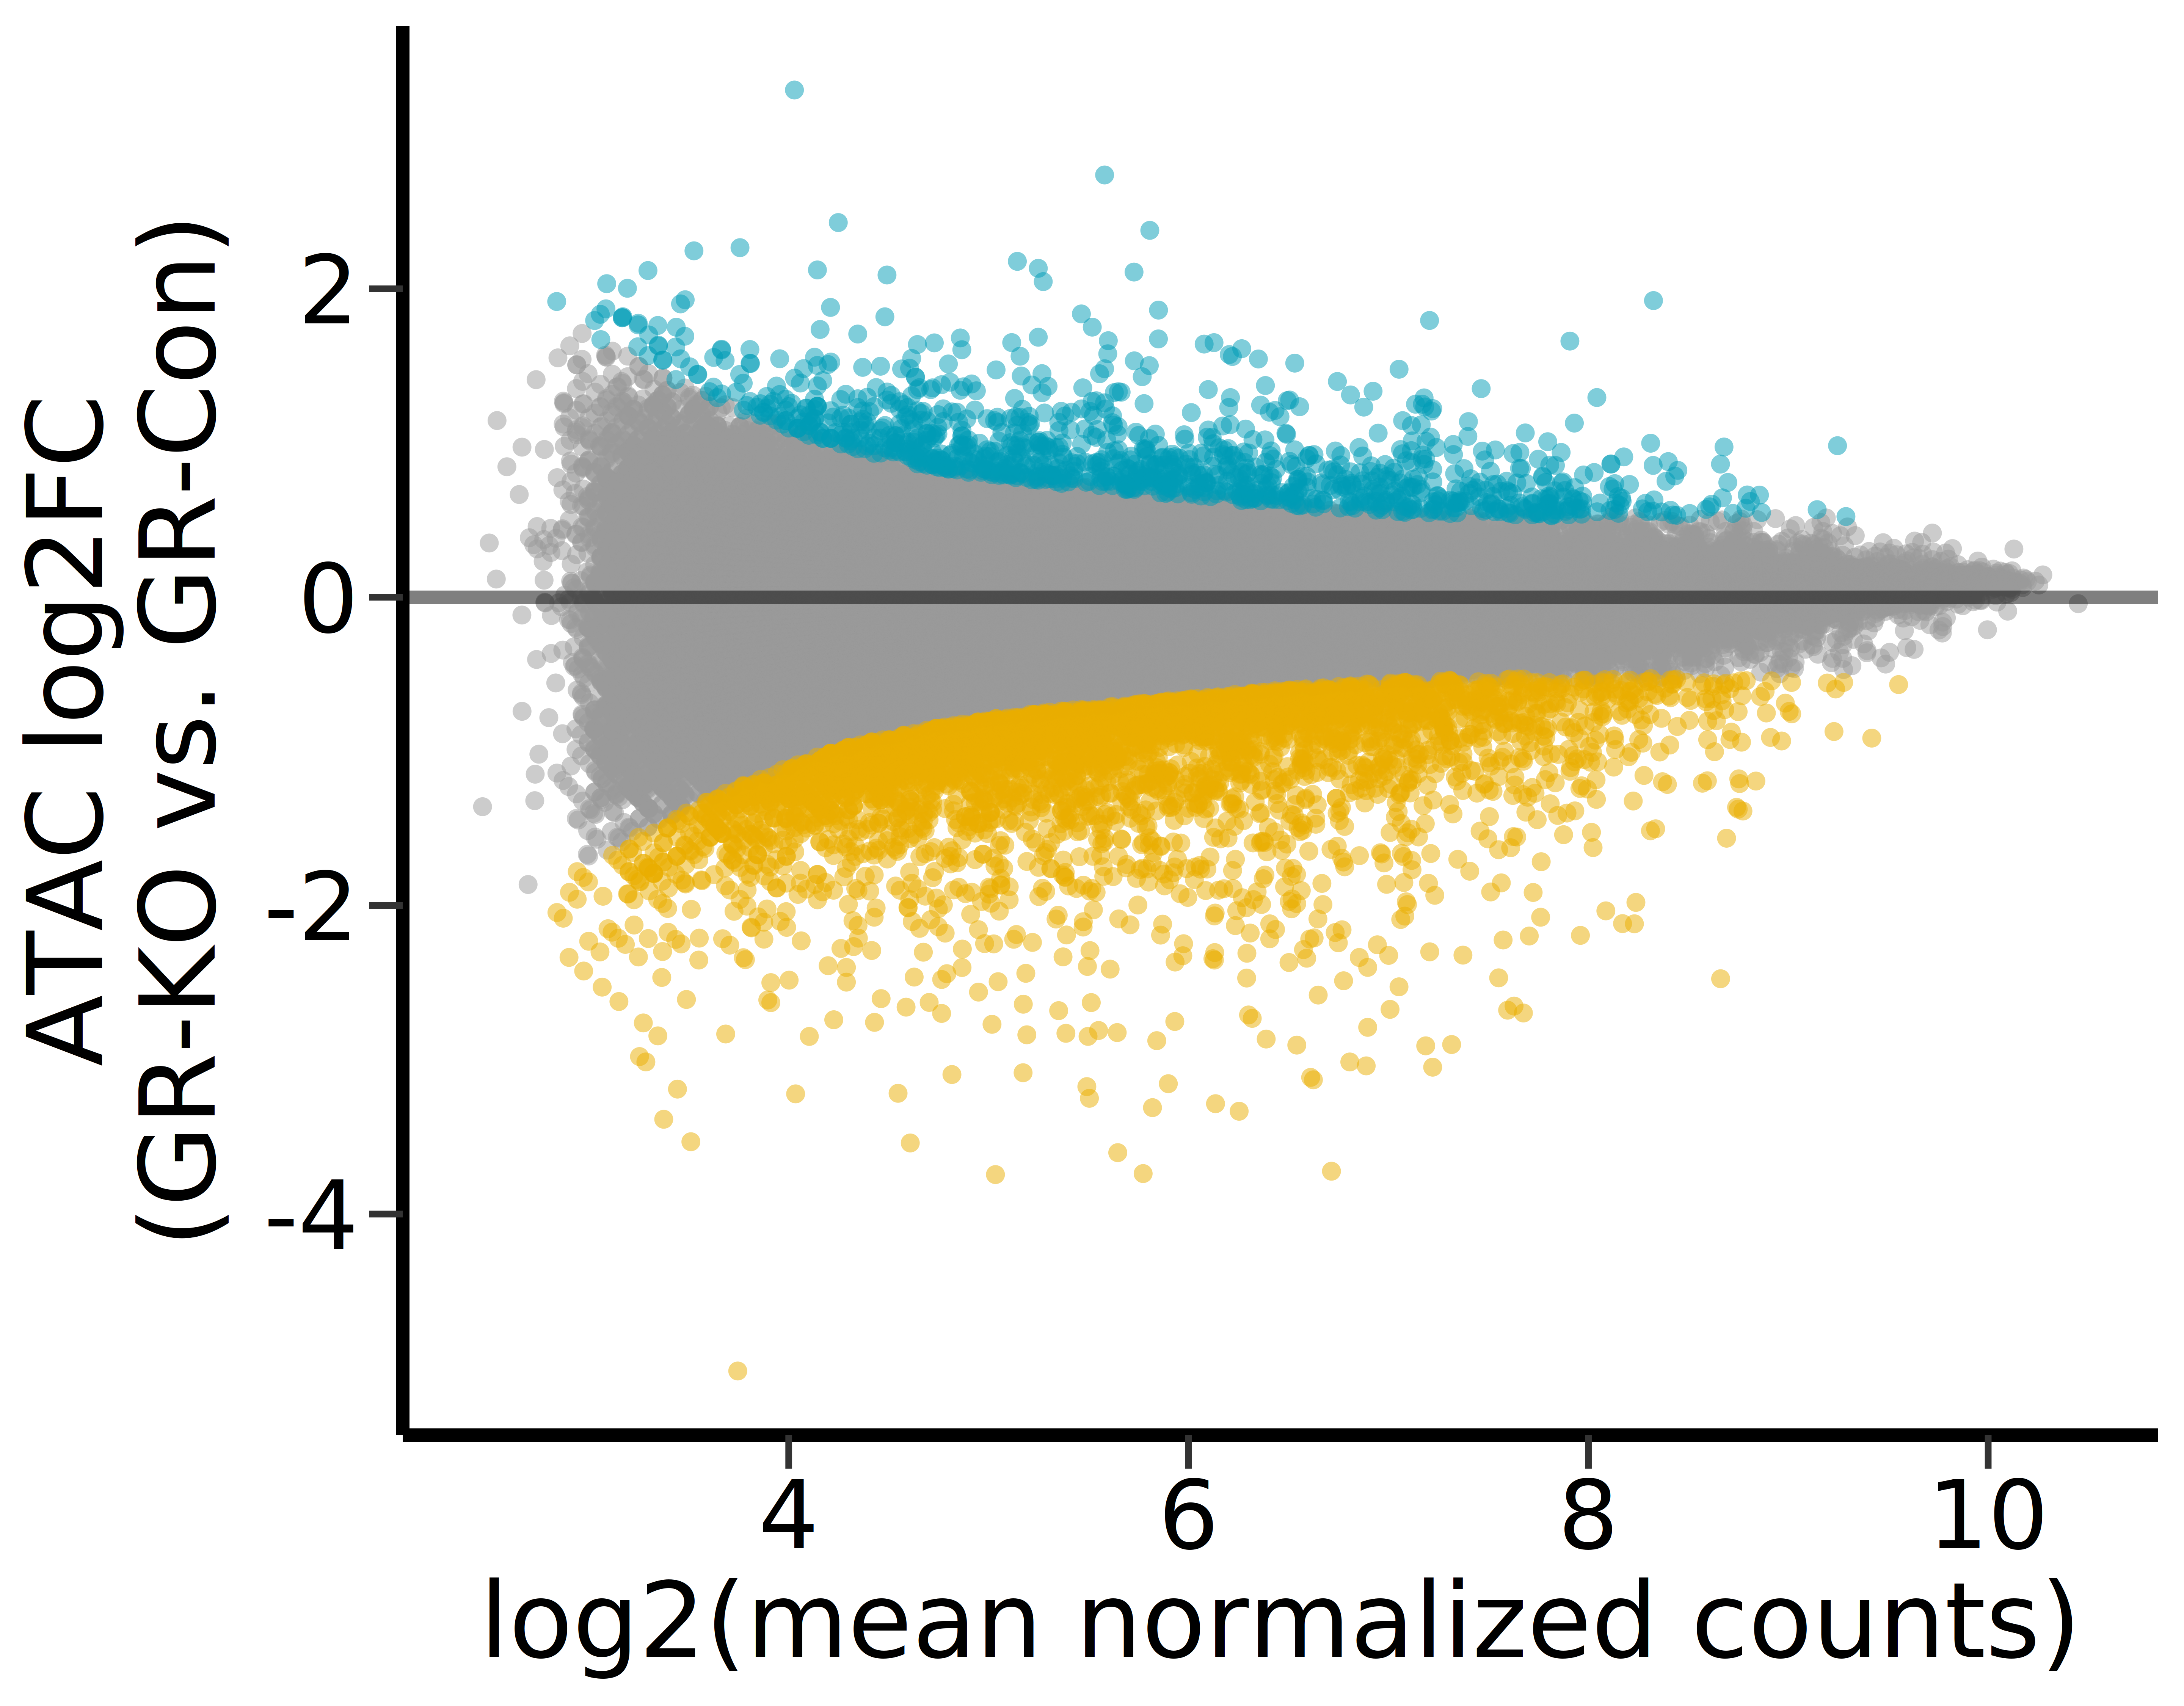

In [14]:
# Make MA plot
options(repr.plot.width=6.4, repr.plot.height=5,repr.plot.res=900)

p8 <- ggplot(data = ATAC_count_edger_df %>% arrange(desc(significant)), aes(x = Conc, y = Fold, col = significant)) + 
geom_point(shape=16,size=1.5,alpha=0.5) + 
    geom_hline(yintercept=0, linetype="solid",alpha=0.5, color = "black",size=1) +
    theme_classic() + 
    scale_color_manual(values = c("#009CB5",
                                  "#EAAE00",
                                  "grey60")) +
    theme(axis.text = element_text(size = 20, color = 'black'),
          axis.title = element_text(size = 22),
          axis.line = element_line(size = 1),
          axis.ticks.length=unit(.25, "cm"),
          plot.title = element_text(size = 20, hjust = 0.5),
          legend.position = 'None') +
    xlab('log2(mean normalized counts)') +
    ylab('ATAC log2FC\n(GR-KO vs. GR-Con)') 

p8

In [61]:
# Export results to BED files for analysis
rtracklayer::export(ATAC_count_edger_report[(ATAC_count_edger_report$Fold < 0) &
                                            (ATAC_count_edger_report$FDR < 0.05), ],
					'/n/groups/neuroduo/Bruno/Astro_GR_KO_ATAC/GR_KO_EDGER_down_final.bed',
                    format = 'BED')

rtracklayer::export(ATAC_count_edger_report[(ATAC_count_edger_report$Fold > 0) &
                                            (ATAC_count_edger_report$FDR < 0.05), ],
					'/n/groups/neuroduo/Bruno/Astro_GR_KO_ATAC/GR_KO_EDGER_up_final.bed',
                    format = 'BED')